In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import scipy as sp
import warnings
warnings.filterwarnings('ignore')
%config inlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSDV_Assignment_3_Data/Data.csv")
ncap_funding = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSDV_Assignment_3_Data/NCAP_Funding.csv")
state_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSDV_Assignment_3_Data/State_data.csv")

We are converting the "Timestamp" column type from object to datetime, for easier filtering of data in temporal situations.

In [4]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

<ul><li>The columns address, state, etc. are missing fro some stations. These are imputed using mode.</li>
<li>Whereas PM2.5 and PM10 columns are left as it is. This is because imputation of these columns is meaningless, as sevral factors contribute to the PM value recorded that particular day. These can population present in city, government policies introduced, constructions going on, disasters like wildfires etc.</li></ul>

In [5]:
data['address'] = data.groupby('station')['address'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
data['city'] = data.groupby('station')['city'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
data['state'] = data.groupby('station')['state'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
data['latitude'] = data.groupby('station')['latitude'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
data['longitude'] = data.groupby('station')['longitude'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [6]:
data.isnull().sum()

,0
Timestamp,0
station,0
PM2.5,899113
PM10,928447
address,0
city,0
latitude,0
longitude,0
state,0


In [7]:
state_data.index = state_data["State"]
state_data.drop("State", axis = 1, inplace = True)
state_data.head()

,Population,Area (km2)
State,,
Uttar Pradesh,199812341,240928
Maharashtra,112374333,307713
Bihar,104099452,94163
West Bengal,91276115,88752
Madhya Pradesh,72626809,308252


# Spatial Aggregation
Q1. Which state (consider all stations in that state) has the highest average PM2.5 concentration across all stations and across all years?

In [8]:
grpby_state = data.groupby("state")["PM2.5"].mean()
print(f"The state with highest average overall PM2.5 concentration is {grpby_state.idxmax()} and the average is {grpby_state.max()}")

The state with highest average overall PM2.5 concentration is Delhi and the average is 104.1009176780069


Q2. Which state (consider all stations in that state) had the most days with hazardous PM2.5 levels (above 300 µg/m³) for the year 2023?


In [9]:
d2023 = data[data["Timestamp"].dt.year == 2023]
high_pm25_days = d2023.groupby(["state","Timestamp"])["PM2.5"].mean()
que300 = high_pm25_days[high_pm25_days > 300]
display(que300)
high_pm25_days = que300.groupby("state").count()
print(f"The state with highest hazardous days is {high_pm25_days.idxmax()} and the no of days is {high_pm25_days.max()}")

state      Timestamp 
Delhi      2023-01-09    374.671138
           2023-11-02    315.417983
           2023-11-03    311.521482
           2023-11-04    336.308594
           2023-11-05    329.718115
           2023-11-09    329.369491
           2023-11-13    300.986462
           2023-11-16    327.326339
           2023-11-24    302.523273
           2023-12-22    312.283059
           2023-12-23    314.694096
Jharkhand  2023-08-06    492.672222
Name: PM2.5, dtype: float64

The state with highest hazardous days is Delhi and the no of days is 11


Q3. Which state has the highest variability in PM2.5 levels across its monitoring stations in 2023? (Think how would you measure variability)

In [10]:
df_2023 = data.groupby("state")["PM2.5"].std()
print("The states and their standard deviation are :\n\n", df_2023)

print(f"\nState with highest variabilty in PM2.5 concentration during 2023 is {df_2023.idxmax()}\n\n")

The states and their standard deviation are :

 state
Andhra Pradesh       27.347496
Arunachal Pradesh    14.896228
Assam                54.381690
Bihar                64.423447
Chandigarh           38.763641
Chhattisgarh         18.477318
Delhi                84.553452
Gujarat              33.048510
Haryana              56.581147
Himachal Pradesh     43.765918
Jammu and Kashmir    17.771092
Jharkhand            40.026387
Karnataka            29.598015
Kerala               21.064533
Madhya Pradesh       37.701129
Maharashtra          34.617752
Manipur              81.014387
Meghalaya            34.966046
Mizoram              14.279729
Nagaland             21.027482
Odisha               37.384961
Puducherry           16.464800
Punjab               36.901107
Rajasthan            39.355127
Sikkim               14.743393
Tamil Nadu           27.628518
Telangana            23.802161
Tripura              43.340498
Uttar Pradesh        65.887195
Uttarakhand          23.864999
West Bengal     

We can check the variability by ploting the graphs. We are comparing Delhi, Gujarat and Meghalaya

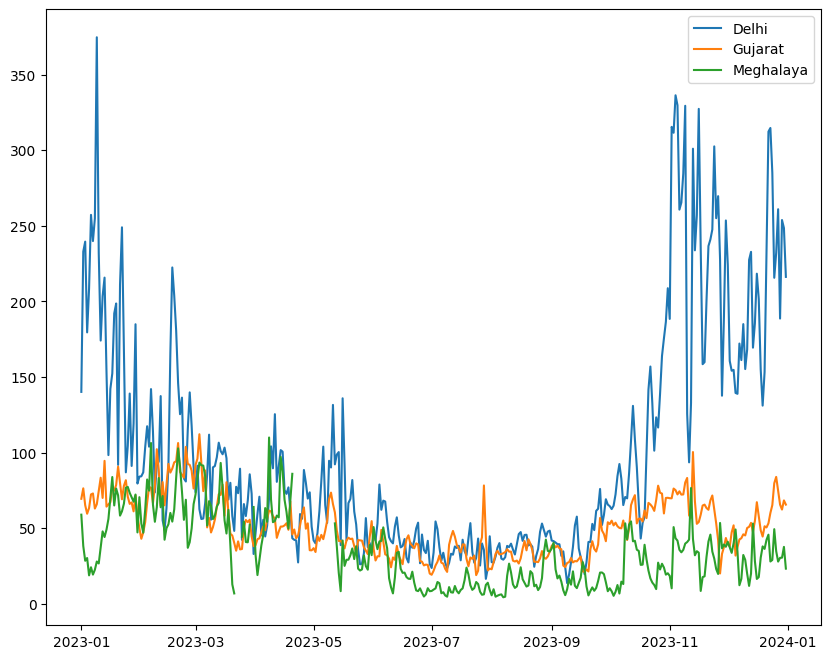

In [11]:
states = ["Delhi", "Gujarat", "Meghalaya"]

fig = plt.figure(figsize = (10, 8))
for sample in states:
  dd = data[(data["Timestamp"].dt.year == 2023) & (data['state'] == sample)]
  grpby = dd.groupby("Timestamp").agg({"PM2.5":["mean"]})
  plt.plot(grpby.index, grpby[('PM2.5', 'mean')], label = sample)
plt.legend()
plt.show()

Q4. Which state has the lowest average PM2.5 levels during the Covid period (The year 2020-2021 both years inclusive)?

In [12]:
dcovid = data[(data["Timestamp"].dt.year == 2020) | (data["Timestamp"].dt.year == 2021)]
grpby_state = dcovid.groupby(["state"])["PM2.5"].mean()
print(f"The state with lowest average PM2.5 concentration during Covid is {grpby_state.idxmin()} and the average is {grpby_state.min()}")

The state with lowest average PM2.5 concentration during Covid is Mizoram and the average is 14.323350150801287


#Temporal Aggregation

Q1. Report the station that recorded the highest value of PM 2.5 for the month Aug of 2020.


In [13]:
dAug2020 = data[(data["Timestamp"].dt.year == 2020) & (data["Timestamp"].dt.month == 8)]
grpby_station = dAug2020.groupby(["station"])["PM2.5"].max()
print(f"The station that recorded highest PM2.5 concentration is {grpby_station.idxmax()} and the recorded value is {grpby_station.max()}")

The station that recorded highest PM2.5 concentration is Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB and the recorded value is 805.51


Defining a function to distinguish months based on season.

In [14]:
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'ND'

Q2. For the year 2018, calculate the average PM2.5 concentration for each season. Seasons being Winter: December-February, Summer: March-May, and Monsoon: June-September) for stations Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB. Identifying the season with the highest pollution.
[Thought Question] Can you suggest some potential factors on why certain seasons are generally more polluted than others?


In [15]:
dLBSNK = data[(data["station"] == "Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB") & (data["Timestamp"].dt.year == 2018)]
dLBSNK['Season'] = dLBSNK['Timestamp'].dt.month.apply(season)
grpby_season = dLBSNK.groupby("Season")["PM2.5"].mean()
print(f"The season which is polluted around Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB is {grpby_season.idxmax()} and the average PM2.5 conc. value is {grpby_season.max()}")

The season which is polluted around Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB is Winter and the average PM2.5 conc. value is 67.4923443634478


**There are several factors which influence the on how much amount of pollution is produced. They are:** <ul>
<li>Atmospheric conditions like wind speed, humidity, temperature, pressure etc. </li>
<li>Social conditons like no. of holidays, congested roads, amount of power consumed, etc.</li></ul>

Q3. Compare the average PM2.5 levels during weekends and weekdays for the station Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB over the year 2021. Create a plot to show these trends Steps:<ul>
<li>Calculate the monthly average PM2.5 for weekdays and weekends separately</li>
<li>X-axis: Months (January to December).</li>
<li>Y-axis: Average PM2.5 levels.</li>
<li>Use two lines: one for the monthly average PM2.5 levels on weekdays and one for weekends.</li></ul>

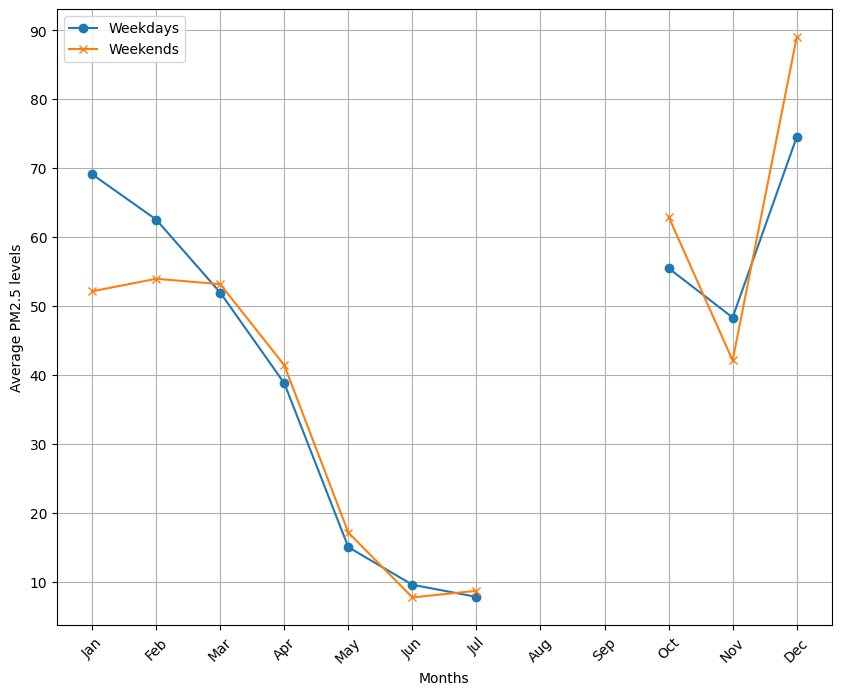

In [16]:
dLBSNK = data[(data["station"] == "Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB") & (data["Timestamp"].dt.year == 2021)]
dLBSNK['daytype'] = dLBSNK['Timestamp'].dt.strftime('%A').isin(['Saturday','Sunday'])
dLBSNK['month'] = dLBSNK['Timestamp'].dt.month
grpby_daytype = dLBSNK.groupby(["month","daytype"])["PM2.5"].mean()
grpby_daytype = grpby_daytype.unstack()

plt.figure(figsize=(10,8))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(grpby_daytype.index, grpby_daytype[False], label = "Weekdays", marker = 'o')
plt.plot(grpby_daytype.index, grpby_daytype[True], label = "Weekends", marker = 'x')
plt.tick_params(axis = 'x', labelrotation = 45)
plt.xticks(range(1,13), months)

plt.xlabel("Months")
plt.ylabel("Average PM2.5 levels")
plt.legend()
plt.grid()
plt.show()

# Spatio Temporal Aggregation

Q1. For each state, calculate the percentage increase or decrease in PM2.5 levels during monsoon months (June to September) compared to summer months (March to May). Which state has the most difference (increase or decrease) for the year 2022?

In [17]:
d2022 = data[data['Timestamp'].dt.year == 2022]

d2022['Season'] = d2022['Timestamp'].dt.month.apply(season)
grpby_season = d2022.groupby(["state", "Season"])["PM2.5"].mean()
grpby_season = grpby_season.unstack()
grpby_season['difference (MS)'] = np.abs((grpby_season[('Monsoon')] - grpby_season[('Summer')])/ grpby_season[('Monsoon')]*100)
print(f"The state which has the most change in PM2.5 values from summer to monsoon is {grpby_season['difference (MS)'].idxmax()} and the percentage change is {grpby_season['difference (MS)'].max()}")

The state which has the most change in PM2.5 values from summer to monsoon is Assam and the percentage change is 157.575412362881


Q2. Plot the average PM2.5 levels for Delhi across each season (Winter: December-February, Summer: March-May, Monsoon: June-September) from 2017 to 2023. What seasonal variation, if any, can you observe in pollution levels?


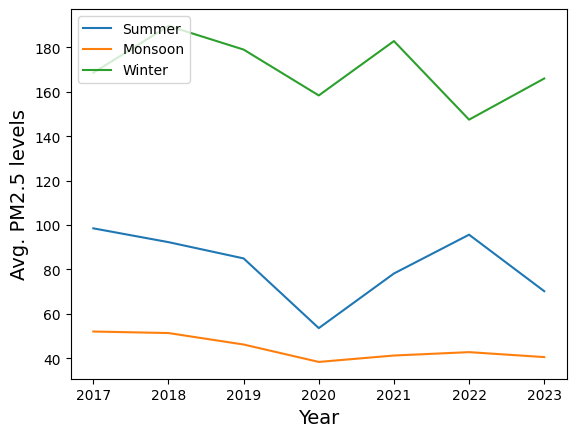

In [18]:
dd_17_23 = data[(data["state"] == "Delhi") & ((data["Timestamp"].dt.year >=2017) & (data["Timestamp"].dt.year <= 2023))]
dd_17_23['Season'] = dd_17_23['Timestamp'].dt.month.apply(season)
dd_17_23['Year'] = dd_17_23['Timestamp'].dt.year
grpby_season = dd_17_23.groupby(["Year", "Season"]).agg({"PM2.5":["mean"]})
grpby_season = grpby_season.unstack()

seasons = ['Summer', 'Monsoon', 'Winter']
for season in seasons:
  plt.plot(grpby_season.index, grpby_season[('PM2.5', 'mean', season)], label = season)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Avg. PM2.5 levels", fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

**We can observe that winter has the highest amount of pollution produced across all years. This is because the cold temperatures in winter forces us to produce heat to keep ourselves warm. The pollution can be produced through burning of wood, excessive usage of electricity to power heaters, geysers etc.**

Q3. Plot a time-series graph comparing Delhi’s PM2.5 levels with Mumbai’s from 2015 to 2023. Which city had more fluctuations? (Hint: Think what fluctuation means)

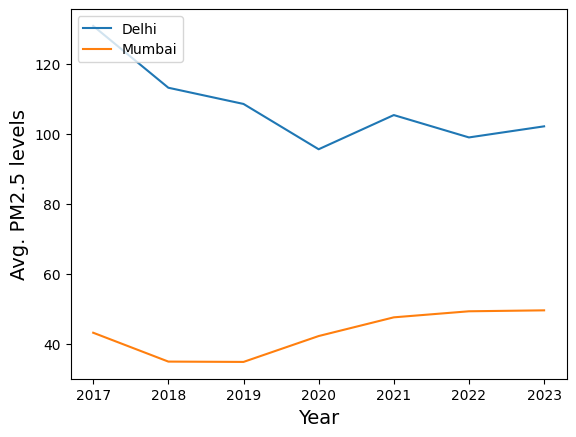

In [19]:
data_delhi = data[(data["city"] == "Delhi") & ((data["Timestamp"].dt.year >=2015) & (data["Timestamp"].dt.year <= 2023))]
data_delhi['Year'] = data_delhi['Timestamp'].dt.year
grpby_delhi = data_delhi.groupby(["Year"]).agg({"PM2.5":["mean"]})
plt.plot(grpby_delhi.index, grpby_delhi[('PM2.5', 'mean')], label = "Delhi")

data_mumbai = data[(data["city"] == "Mumbai") & ((data["Timestamp"].dt.year >=2015) & (data["Timestamp"].dt.year <= 2023))]
data_mumbai['Year'] = data_mumbai['Timestamp'].dt.year
grpby_mumbai = data_mumbai.groupby(["Year"]).agg({"PM2.5":["mean"]})
plt.plot(grpby_mumbai.index, grpby_mumbai[('PM2.5', 'mean')], label = "Mumbai")
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Avg. PM2.5 levels", fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

**Delhi has more fluctuations compared to Mumbai. Fluctuation here can be determined using several methods like variance, range of data or movement of graph etc. Here based on the movement of graph and range of data, as Delhi's pollution levels have been constantly increasing and decreasing, we can say it is more fluctuating.**

#Population Based

Q1. Which state in India has the highest number of monitoring stations relative to its population?

In [20]:
grpby_state = data.groupby(["state"]).nunique()
state_data["per pop stations"] = grpby_state["station"] / state_data["Population"]
print(f"The state which has the highest number of monitoring stations relative to its population is {state_data['per pop stations'].idxmax()} and ratio is {state_data['per pop stations'].max()}")

The state which has the highest number of monitoring stations relative to its population is Chandigarh and ratio is 2.8423895021081055e-06


Q2. Plot a bar chart showing the top 5 most polluted states in terms of per capita PM2.5 exposure in 2023.

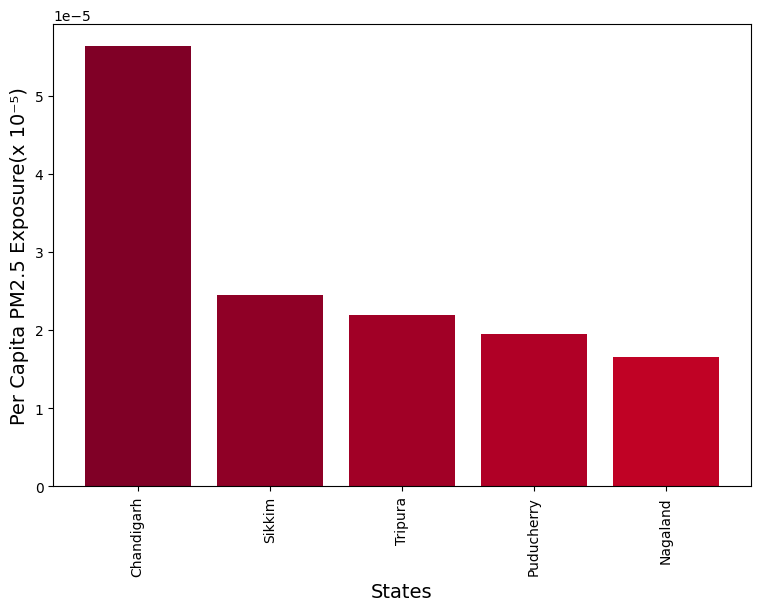

In [21]:
d2023 = data[(data["Timestamp"].dt.year == 2023)]
grpby_state = d2023.groupby(["state"]).agg({"PM2.5":["mean"]})
state_data["per pop conc"] = grpby_state[('PM2.5', 'mean')] / state_data["Population"]
state_data.sort_values(by = "per pop conc", ascending = False, inplace = True)

colors = cm.YlOrRd(np.linspace(1, 0, len(state_data)))
fig = plt.figure(figsize = (9, 6))
plt.bar(state_data.index[:5], state_data["per pop conc"][:5], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("States", fontsize = 14)
plt.ylabel("Per Capita PM2.5 Exposure(x 10⁻⁵)", fontsize = 14)
plt.show()

Q3. Plot the relationship between population density and average PM2.5 concentration for each state. What conclusion can you draw about the correlation between population density and pollution? <ul>
<li>X-axis: Population density (people per square kilometer).</li>
<li>Y-axis: Average PM2.5 concentration.</li>
<li>Use a scatter plot to show the relationship, where each point represents a state.</li></ul>

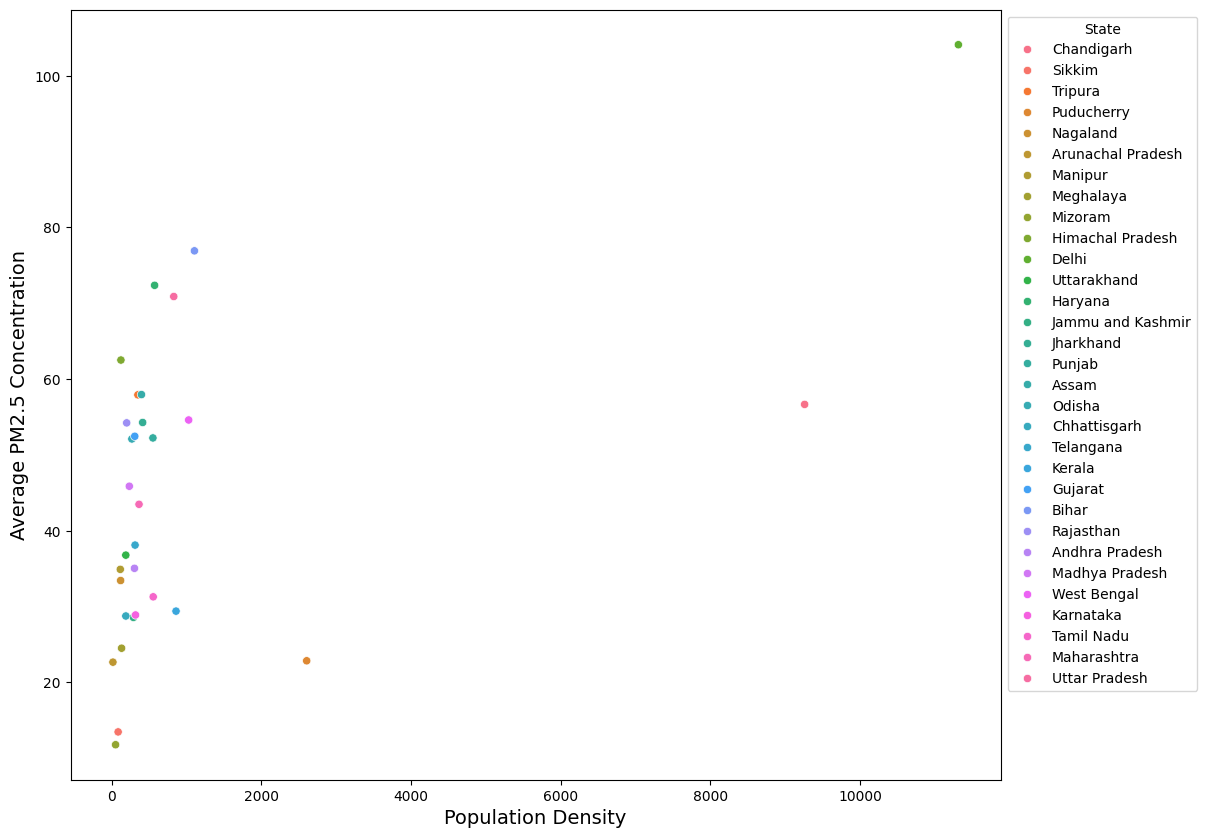

In [22]:
state_data["Population Density"] = state_data["Population"] / state_data["Area (km2)"]
grpby_state = data.groupby(["state"])["PM2.5"].mean()
merge_df = pd.merge(state_data, grpby_state, left_index = True, right_index = True)

plt.figure(figsize = (12, 10))
sns.scatterplot(data = merge_df, x = "Population Density", y = "PM2.5", hue = merge_df.index)
plt.xlabel("Population Density", fontsize = 14)
plt.ylabel("Average PM2.5 Concentration", fontsize = 14)
plt.legend(title="State", bbox_to_anchor=(1, 1), loc="upper left")

plt.show()

**We can see that as the population density is increasing the PM2.5 value is also increasing rapidly. For very high density states like Delhi, PM2.5 concentration is very high (>100).**

# Area Based

Q1. Which state has the highest PM2.5 concentration per square kilometer? Plot the pollution levels for all states relative to their area. <ul>
<li>X-axis: States.</li>
<li>Y-axis: PM2.5 concentration per square kilometer.</li>
<li>Use a bar plot where each bar represents a state, and the height shows PM2.5 per sq km.</li></ul>

The state which has the highest PM2.5 concentration per square kilometer is Chandigarh and ratio is 0.49707721560304186


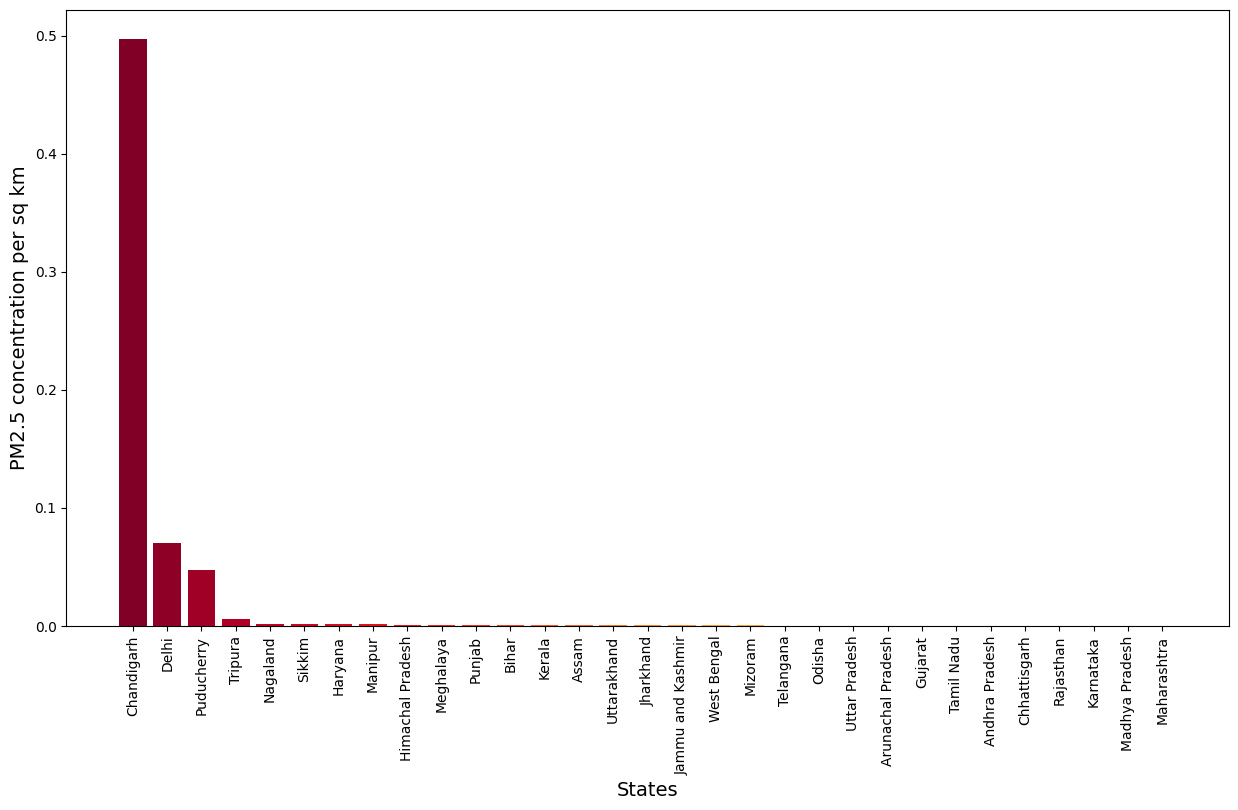

In [23]:
grpby_state = data.groupby(["state"]).agg({"PM2.5":["mean"]})
state_data["per km conc"] = grpby_state[('PM2.5', 'mean')] / state_data["Area (km2)"]
state_data.sort_values(by = "per km conc", ascending = False, inplace = True)
print(f"The state which has the highest PM2.5 concentration per square kilometer is {state_data['per km conc'].idxmax()} and ratio is {state_data['per km conc'].max()}")

colors = cm.YlOrRd(np.linspace(1, 0, len(state_data)))
fig = plt.figure(figsize = (15, 8))
plt.bar(state_data.index, state_data["per km conc"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("States", fontsize = 14)
plt.ylabel("PM2.5 concentration per sq km", fontsize = 14)
plt.show()

Q2. Compare the total number of monitoring stations per square kilometer in each state. Identify the state with the highest density of monitoring stations relative to its area. Show a bar plot where each bar represents a state, and the height shows the number of monitoring stations per square kilometer.

The state which has the highest no. of monitoring stations per square kilometer is Chandigarh and ratio is 0.008771929824561403


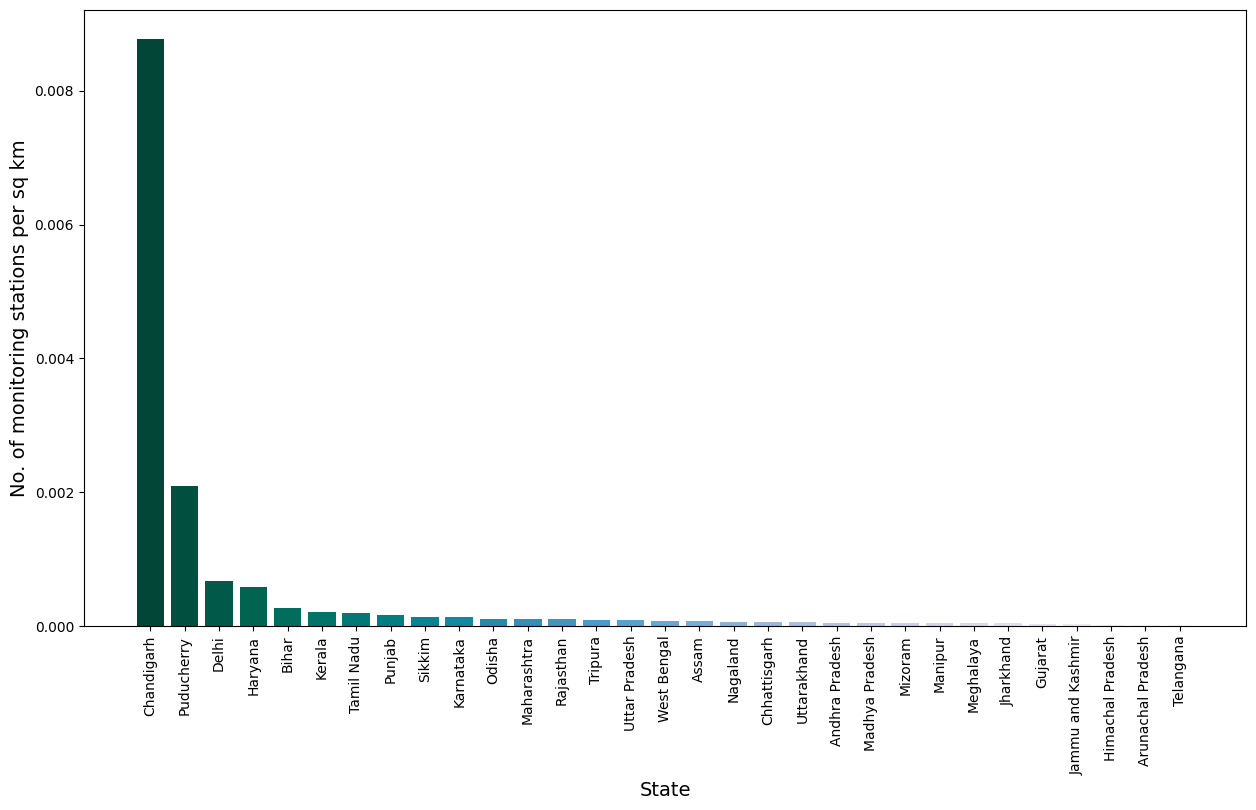

In [24]:
grpby_state = data.groupby(["state"]).nunique()
state_data["per km stations"] = grpby_state["city"] / state_data["Area (km2)"]
state_data.sort_values(by = "per km stations", ascending = False, inplace = True)
print(f"The state which has the highest no. of monitoring stations per square kilometer is {state_data['per km stations'].idxmax()} and ratio is {state_data['per km stations'].max()}")

colors = cm.PuBuGn(np.linspace(1, 0, len(state_data)))
fig = plt.figure(figsize = (15, 8))
plt.bar(state_data.index, state_data["per km stations"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("State", fontsize = 14)
plt.ylabel("No. of monitoring stations per sq km", fontsize = 14)
plt.show()

Q3. Compare the average PM2.5 levels between Maharashtra and Madhya Pradesh over the year 2021. Given that both states have similar area sizes but different population densities, analyze how population density impacts pollution levels in these two states.

In [25]:
data_exclusive = data[(data["state"] == "Maharashtra") | (data["state"] == "Madhya Pradesh")]
data_exclusive = data_exclusive[data_exclusive["Timestamp"].dt.year == 2021]
grpby_state = data_exclusive.groupby(["state"]).agg({"PM2.5":["mean"]})
print(grpby_state)
grpby_popdens = state_data.loc[["Maharashtra", "Madhya Pradesh"], "Population Density"]
print("\n\n",grpby_popdens)

                    PM2.5
                     mean
state                    
Madhya Pradesh  47.095952
Maharashtra     46.440044


 State
Maharashtra       365.192023
Madhya Pradesh    235.608557
Name: Population Density, dtype: float64


**Here we can see that even when MP has lower population density, it still faces the same level pollution as MH, as population density on overall state is not the only factor which influences pollution. The urban centres of MP are on apr with that those of MH, in terms of generating pollution.
 Here MH is Maharashtra, and MP is Madhya Pradesh**

# Funding Based

Q1. Compare the average PM2.5 levels between states that received NCAP funding and those that did not in 2021.

In [26]:
funding_column = "Amount released during FY 2021-22"
state_column = "State"

ncap_funding[funding_column] = pd.to_numeric(ncap_funding[funding_column], errors="coerce").fillna(0)
state_funding = ncap_funding.groupby(state_column)[funding_column].sum()

funded_states = set(state_funding[state_funding > 0].index)
non_funded_states = set(state_funding[state_funding == 0].index)
funded_states = list(funded_states)
funded_states = sorted(funded_states)
funded_states[5] = funded_states[5].replace("&", "and")
non_funded_states = list(non_funded_states)

print("States that received funding in FY 2021-22:")
print(sorted(funded_states))

print("\nStates that did NOT receive funding in FY 2021-22:")
print(sorted(non_funded_states))


States that received funding in FY 2021-22:
['Andhra Pradesh', 'Bihar', 'Chandigarh', 'Delhi', 'Himachal Pradesh', 'Jammu and Kashmir', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Nagaland', 'Odisha', 'Telangana', 'Uttar Pradesh', 'Uttarakhand']

States that did NOT receive funding in FY 2021-22:
['Assam', 'Chhattisgarh', 'Gujarat', 'Jharkhand', 'Meghalaya', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'West Bengal']


In [27]:
df_2020 = data[data["Timestamp"].dt.year == 2020]
state_pm25_2020 = df_2020.groupby("state")["PM2.5"].mean()

print("Average PM2.5 levels for each state in 2020:")
print(state_pm25_2020)

Average PM2.5 levels for each state in 2020:
state
Andhra Pradesh       30.425130
Arunachal Pradesh          NaN
Assam                62.329410
Bihar                64.782514
Chandigarh           32.894744
Chhattisgarh               NaN
Delhi                95.639458
Gujarat              48.396896
Haryana              68.260080
Himachal Pradesh           NaN
Jammu and Kashmir          NaN
Jharkhand            57.042476
Karnataka            28.898024
Kerala               25.278445
Madhya Pradesh       42.870198
Maharashtra          41.434119
Manipur                    NaN
Meghalaya            19.866194
Mizoram              13.420796
Nagaland             29.208632
Odisha               55.663746
Puducherry                 NaN
Punjab               47.381673
Rajasthan            50.445354
Sikkim                     NaN
Tamil Nadu           30.910889
Telangana            36.197592
Tripura              76.015590
Uttar Pradesh        93.632244
Uttarakhand                NaN
West Bengal        

In [28]:
funded = state_pm25_2020[funded_states]
non_funded = state_pm25_2020[non_funded_states]
print("The states with funding:\n\n")
display(funded)
print("\n\n")
print("The states with no funding:\n\n")
display(non_funded)

The states with funding:




,PM2.5
state,
Andhra Pradesh,30.425130
Bihar,64.782514
Chandigarh,32.894744
Delhi,95.639458
Himachal Pradesh,NaN
Jammu and Kashmir,NaN
Karnataka,28.898024
Madhya Pradesh,42.870198
Maharashtra,41.434119





The states with no funding:




,PM2.5
state,
Gujarat,48.396896
Meghalaya,19.866194
Rajasthan,50.445354
Assam,62.329410
Jharkhand,57.042476
Tamil Nadu,30.910889
West Bengal,51.951470
Punjab,47.381673
Chhattisgarh,NaN


In [29]:
df_2021 = data[data["Timestamp"].dt.year == 2021]
state_pm25_2021 = df_2021.groupby("state")["PM2.5"].mean()

print("Average PM2.5 levels for each state in 2021:")
print(state_pm25_2021)

Average PM2.5 levels for each state in 2021:
state
Andhra Pradesh        33.316491
Arunachal Pradesh     14.751325
Assam                 61.017780
Bihar                 81.967836
Chandigarh            44.360885
Chhattisgarh          24.863968
Delhi                105.401629
Gujarat               50.780194
Haryana               75.320179
Himachal Pradesh            NaN
Jammu and Kashmir     31.909474
Jharkhand                   NaN
Karnataka             26.745015
Kerala                27.333550
Madhya Pradesh        47.095952
Maharashtra           46.440044
Manipur                     NaN
Meghalaya             12.197489
Mizoram               14.876038
Nagaland              33.437906
Odisha                37.812390
Puducherry            20.198304
Punjab                51.940080
Rajasthan             61.923695
Sikkim                      NaN
Tamil Nadu            28.896307
Telangana             39.646620
Tripura               46.273125
Uttar Pradesh         82.596457
Uttarakhand          

In [30]:
funded = state_pm25_2021[funded_states]
non_funded = state_pm25_2021[non_funded_states]
print("The states with funding:\n\n")
display(funded)
print("\n\n")
print("The states with no funding:\n\n")
display(non_funded)

The states with funding:




,PM2.5
state,
Andhra Pradesh,33.316491
Bihar,81.967836
Chandigarh,44.360885
Delhi,105.401629
Himachal Pradesh,NaN
Jammu and Kashmir,31.909474
Karnataka,26.745015
Madhya Pradesh,47.095952
Maharashtra,46.440044





The states with no funding:




,PM2.5
state,
Gujarat,50.780194
Meghalaya,12.197489
Rajasthan,61.923695
Assam,61.017780
Jharkhand,NaN
Tamil Nadu,28.896307
West Bengal,59.391918
Punjab,51.940080
Chhattisgarh,24.863968


**Comparing PM2.5 values between 2020 and 2021 years, we find that most of the states which recieved the NCAP funding for 2021 - 22 term, had increased PM2.5 levels.**

Q2. Create a time series plot showing PM2.5 levels with an increment in NCAP funding for Assam. Has an increment of the financing led to noticeable improvements in air quality?

In [31]:
ncap_funding[ncap_funding["State"] == "Assam"]

,S. No.,State,City,Amount released during FY 2019-20,Amount released during FY 2020-21,Amount released during FY 2021-22,Total fund released,Utilisation as on June 2022
13,14,Assam,Guwahati,0.12,5,0.0,5.12,1.45
14,15,Assam,Nagaon,0.06,2,0.0,2.06,1.45
15,16,Assam,Nalbari,0.06,1,0.0,1.06,1.45
16,17,Assam,Sibsagar,0.06,2,0.0,2.06,1.45
17,18,Assam,Silchar,0.06,2,0.0,2.06,1.45


In [32]:
data["year"] = data["Timestamp"].dt.year
assam_df = data[(data["state"] == "Assam") & (data["year"].isin([2019, 2020, 2021]))]
assam_pm25_avg = assam_df.groupby("year")["PM2.5"].mean()

print("Average PM2.5 levels in Assam (2019-2021):")
print(assam_pm25_avg)

x = assam_pm25_avg.index
y = assam_pm25_avg.values
print(x)
print(y)

Average PM2.5 levels in Assam (2019-2021):
year
2019    55.752773
2020    62.329410
2021    61.017780
Name: PM2.5, dtype: float64
Index([2019, 2020, 2021], dtype='int32', name='year')
[55.75277257 62.32940963 61.01777969]


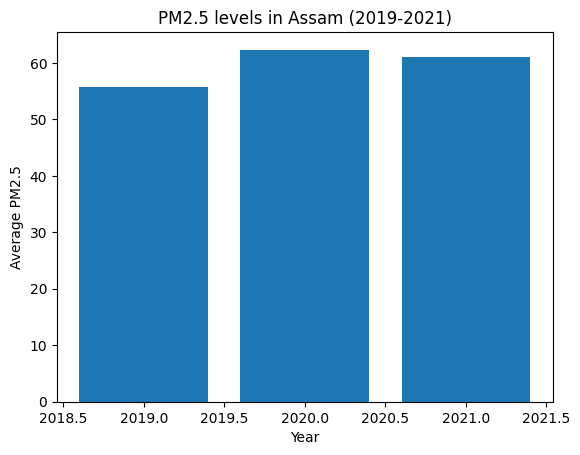

In [33]:
plt.bar(x, y)
plt.title("PM2.5 levels in Assam (2019-2021)")
plt.xlabel("Year")
plt.ylabel("Average PM2.5")
plt.show()

**Comparing the data, we can see after the funds were released in 2020, PM2.5 values decreased in 2021.**

Q3. Create a scatter plot to showcase the area versus funding received by a state. Mark every state with a different color and show the legend outside the plot.


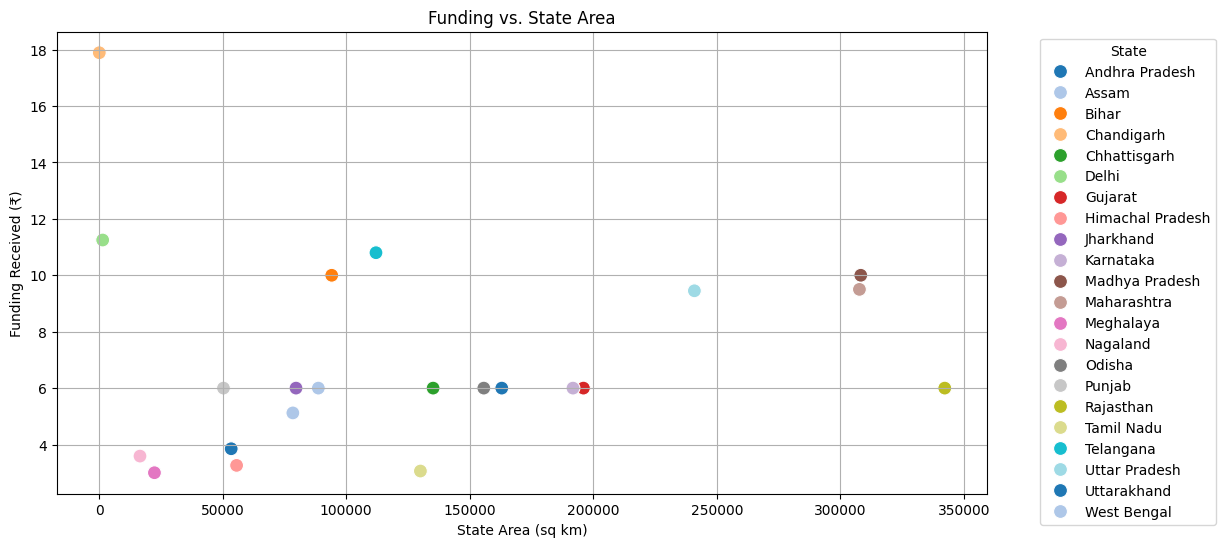

In [34]:
funding_column = "Total fund released"
state_column = "State"
area_column = "Area (km2)"

ncap_funding[funding_column] = pd.to_numeric(ncap_funding[funding_column], errors="coerce").fillna(0)

# Group by state_data to get total funding per state_data
state_funding = ncap_funding.groupby(state_column)[funding_column].first()

# Merge funding data with state_data area data
merged_df = pd.merge(state_funding, state_data, on=state_column, how="inner")

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=merged_df, x=area_column, y=funding_column, hue=state_column, palette="tab20", s=100)

plt.xlabel("State Area (sq km)")
plt.ylabel("Funding Received (₹)")
plt.title("Funding vs. State Area")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

# Miscellaneous Questions

Q1. For the most polluted city in 2023 (highest average pollution in 2023), calculate the percentage of days with PM2.5 levels above the hazardous threshold (300 µg/m³)

In [35]:
df_2023 = data[data["Timestamp"].dt.year == 2023]
city_pm25_avg = df_2023.groupby("city")["PM2.5"].mean()
most_polluted_city = city_pm25_avg.idxmax()
hazardous_days = df_2023[(df_2023["city"] ==city_pm25_avg.idxmax()) & (df_2023["PM2.5"] > 300)]["Timestamp"].count()
percentage_hazardous = (hazardous_days / 365) * 100

print(f"The most poulated city is {city_pm25_avg.idxmax()} with {round(percentage_hazardous,4)} % of hazardous days")

The most poulated city is Darbhanga with 0.8219 % of hazardous days


Q2. Analyze the PM2.5 levels in Delhi during Diwali (October-November) and New Year compared to regular months over the 3 years (2018-2020). Do you observe any significant pollution spikes during these festivals? If spikes are observed, Can you mark these spikes using arrows?

,PM2.5
Timestamp,
2019-11-03,544.710998
2019-11-15,422.658175
2020-11-09,521.682125
2020-11-10,451.726291
2020-11-14,392.898466


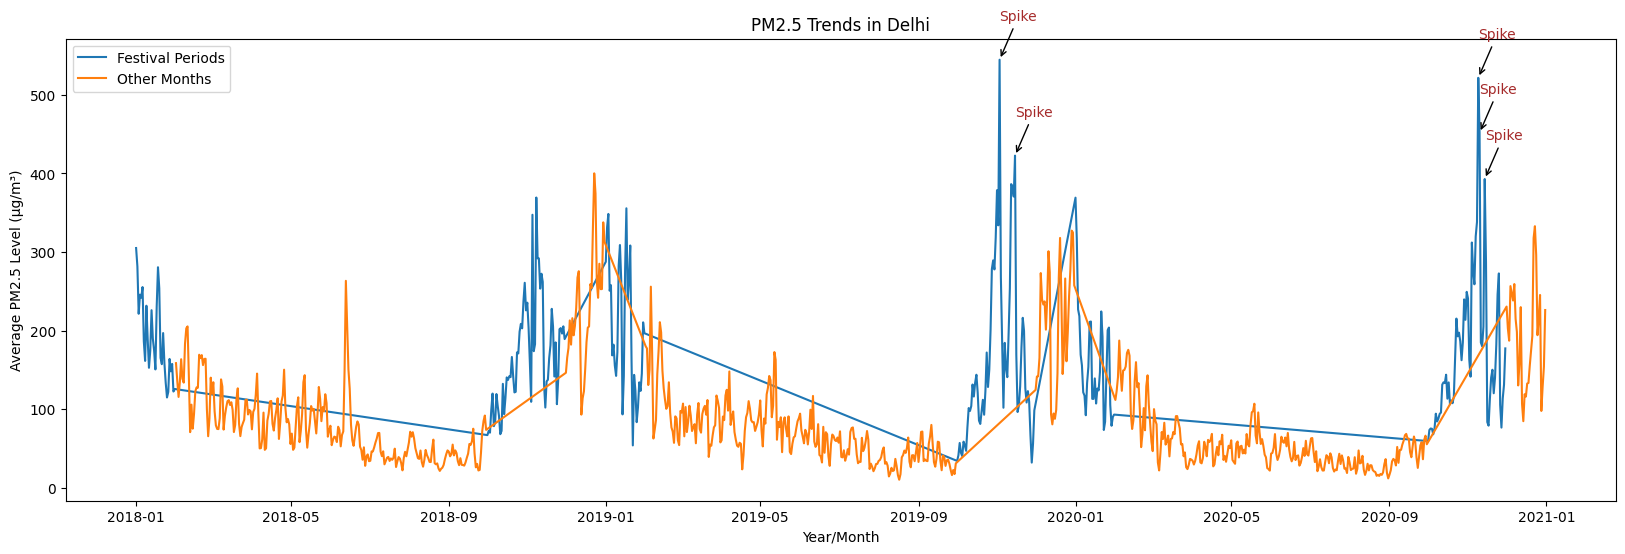

In [36]:
df_delhi = data[data["state"] == "Delhi"]
fest_df= df_delhi[(df_delhi["Timestamp"].dt.month.isin([1, 10, 11])) & (df_delhi["Timestamp"].dt.year.between(2018, 2020))]
normal_periods = df_delhi[~df_delhi["Timestamp"].dt.month.isin([1, 10, 11]) & (df_delhi["Timestamp"].dt.year.between(2018, 2020))]

plt.figure(figsize=(20, 6))
plt.plot(fest_df.groupby("Timestamp")["PM2.5"].mean(), label="Festival Periods")
plt.plot(normal_periods.groupby(data['Timestamp'])["PM2.5"].mean(), label="Other Months")

plt.xlabel("Year/Month")
plt.ylabel("Average PM2.5 Level (µg/m³)")
plt.title("PM2.5 Trends in Delhi")

fest_pm25 = fest_df.groupby(data["Timestamp"].dt.date)["PM2.5"].mean()
spike_threshold = fest_pm25.quantile(0.985)
spike_dates = fest_pm25[fest_pm25 > spike_threshold]
for date, value in spike_dates.items():
    plt.annotate("Spike", xy=(date, value), xytext=(date, value + 50),
                 arrowprops=dict(facecolor="black", arrowstyle="->"),
                 fontsize=10, color="Brown")

plt.legend()
spike_dates

Q3. Identify the state that received the highest NCAP funding in 2020 and determine if its air pollution levels improved significantly by 2023. Use a line graph to compare yearly average PM2.5 trends.

The State that received the highest NCAP funding in 2020 is Chandigarh.


,PM2.5
Timestamp,
2017,NaN
2018,NaN
2019,64.345961
2020,32.894744
2021,44.360885
2022,56.265032
2023,59.414055
2024,67.947498


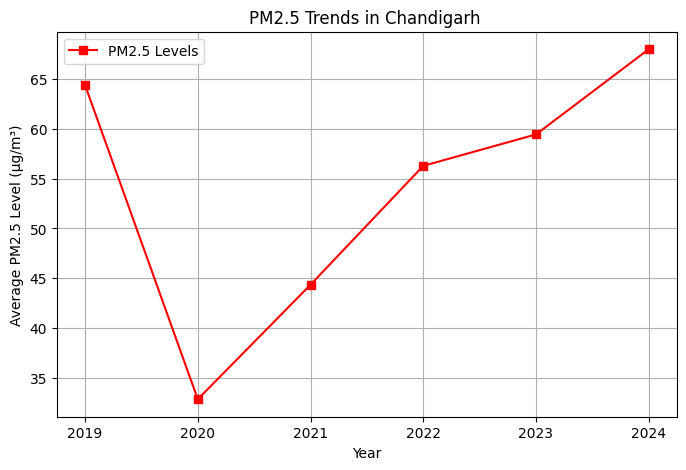

In [37]:
highest_funded_state = ncap_funding.sort_values("Amount released during FY 2020-21", ascending=False)["State"].iloc[0]
pm25_trend = data[data["state"] == highest_funded_state].groupby(data["Timestamp"].dt.year)["PM2.5"].mean()
print(f"The State that received the highest NCAP funding in 2020 is {highest_funded_state}.")
data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")

state_pm25 = data[data["state"] == highest_funded_state]
state_pm25_Trend = state_pm25.groupby(state_pm25["Timestamp"].dt.year)["PM2.5"].mean()

plt.figure(figsize=(8, 5))
plt.plot(state_pm25_Trend.index, state_pm25_Trend.values, marker="s", linestyle="-", color="red", label="PM2.5 Levels")

plt.xlabel("Year")
plt.ylabel("Average PM2.5 Level (µg/m³)")
plt.title(f"PM2.5 Trends in {highest_funded_state} ")
plt.legend()
plt.grid(True)
state_pm25_Trend

Q.4) Draw the map of India and plot the sensor locations on the map.

In [38]:
import pandas as pd
import folium

# Convert latitude and longitude from strings to floats.
# data["latitude"] = pd.to_numeric(data["latitude"], errors="coerce")
# data["longitude"] = pd.to_numeric(data["longitude"], errors="coerce")

#removing NaN value
df_clean = data.dropna(subset=["latitude", "longitude"])


df_grouped = df_clean.groupby("station").agg({
    "latitude": "mean",
    "longitude": "mean",
    "city": "first",
    "state": "first"
}).reset_index()
# this will take the mean of longitude,latitude and take 1st value of city,state to remove same values.

india_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for idx, row in df_grouped.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,  # Marker size
        color="Yellow",  # Marker color
        fill=True,
        fill_color="blue",
        fill_opacity=0.5,  # for inside colour here blue
        popup=f"{row['station']} ({row['city']}, {row['state']})" # to popup the location
    ).add_to(india_map)

india_map.save("grouped_monitoring_stations_map.html")

print(df_grouped.nunique())
display(india_map)

station      561
latitude     560
longitude    560
city         288
state         31
dtype: int64


Q.1) Tell us something interesting from the dataset that we have not asked. Anything that intrigues you, anything that might be useful to the policymakers.

['Andhra Pradesh' 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Delhi'
 'Gujarat' 'Himachal Pradesh' 'Jammu & Kashmir' 'Jharkhand' 'Karnataka'
 'Madhya Pradesh' 'Maharashtra' 'Meghalaya' 'Nagaland' 'Odisha' 'Punjab'
 'Rajasthan' 'Tamil Nadu' 'Telangana' 'Uttar Pradesh' 'Uttarakhand'
 'West Bengal']
State
Andhra Pradesh      11.48
Assam                0.00
Bihar                4.40
Chandigarh           4.61
Chhattisgarh         0.00
Delhi               11.25
Gujarat              0.00
Himachal Pradesh     0.48
Jammu & Kashmir     12.84
Jharkhand            0.00
Karnataka            7.32
Madhya Pradesh       5.02
Maharashtra         11.90
Meghalaya            0.00
Nagaland             0.93
Odisha               3.64
Punjab               0.00
Rajasthan            0.00
Tamil Nadu           0.00
Telangana            0.79
Uttar Pradesh       16.31
Uttarakhand          5.67
West Bengal          0.00
Name: Amount released during FY 2021-22, dtype: float64
['Andhra Pradesh' 'Assam' 'Bihar' 'Chandi

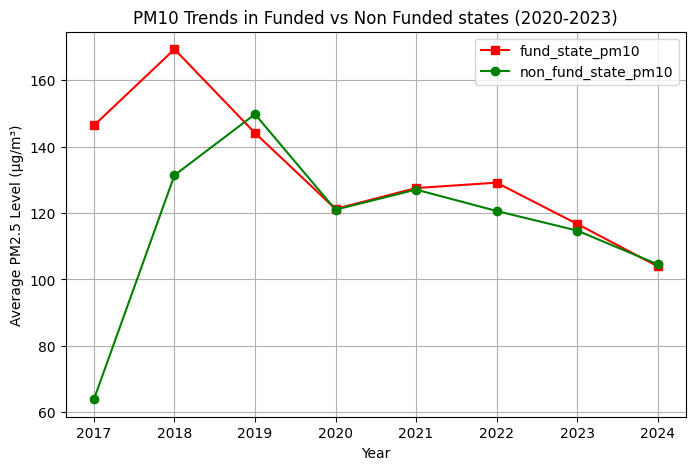

In [39]:
for i  in range(19,22):
    column_name = f'Amount released during FY 20{i}-{i+1}'
    ncap_funding[column_name] = pd.to_numeric(ncap_funding[column_name], errors='coerce').fillna(0)
ncap_funding.replace('-',0)
ncap_gr_State=ncap_funding.groupby('State')['Amount released during FY 2021-22'].sum()
ncap_2021 = ncap_funding[ncap_funding!=0]
ncap_funded_state=ncap_2021['State'].unique()
print(ncap_funded_state)
print(ncap_gr_State)
data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")

print(ncap_funded_state)


avg_pm10_funded = data[data['state'].isin(ncap_funded_state)]["PM10"].mean()   #avg for funded state
avg_pm10_nonfunded = data[~data["state"].isin(ncap_funded_state)]["PM10"].mean() #avg for non funded state

print(f"Average PM10 in Funded States: {avg_pm10_funded:.2f} ")
print(f"Average PM10 in Non-Funded States: {avg_pm10_nonfunded:.2f} ")
fund_state_pm10 = data[data["state"] .isin(ncap_funded_state)]
non_fund_state_pm10 = data[~data["state"] .isin(ncap_funded_state)]

fund_state_pm10_Trend = fund_state_pm10.groupby(fund_state_pm10["Timestamp"].dt.year)["PM10"].mean()
non_fund_state_pm10_Trend = non_fund_state_pm10.groupby(non_fund_state_pm10["Timestamp"].dt.year)["PM10"].mean()
plt.figure(figsize=(8, 5))
plt.plot(fund_state_pm10_Trend.index, fund_state_pm10_Trend.values, marker="s", linestyle="-", color="red", label="fund_state_pm10")
plt.plot(non_fund_state_pm10_Trend.index, non_fund_state_pm10_Trend.values, marker="o", linestyle="-", color="Green", label="non_fund_state_pm10")
# Labels and title
plt.xlabel("Year")
plt.ylabel("Average PM2.5 Level (µg/m³)")
plt.title(f"PM10 Trends in Funded vs Non Funded states (2020-2023)")
plt.legend()
plt.grid(True)

**Therefore we can see that NCAP funded states are able to compete with other states ,after a funding to overcome the additional factors like road dust, construction, and industrial activity,  which are funded state prominent activities. From the graph we can see since it is decreasing so we can say " NCAP funding may have had an impact in controlling the PM10 Particles".**